# Multi Greek Hedging

In [2]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np

from utils.process import process_options,process_underlying,process_rf
from utils.greeks import delta, gamma, vega, theta, rho
from utils.implied_volatility import implied_vol_b76
from tqdm import tqdm

tqdm.pandas()


In [3]:
option_data = pd.read_csv("../data/SPYOPT_processed.csv",parse_dates=True)
underlying = pd.read_csv("../data/SPYFUT_processed.csv",parse_dates=True).rename(columns={'close': 'futures_close'})
rf_rate = pd.read_csv("../data/RFRate.csv", parse_dates=True).rename(columns={'rate': 'rf_rate'})

In [4]:
underlying['ts_event'] = pd.to_datetime(underlying['ts_event'])
underlying['expiration_date'] = pd.to_datetime(underlying['expiration_date'])
rf_rate['ts_event'] = pd.to_datetime(rf_rate['ts_event'])
option_data['ts_event'] = pd.to_datetime(option_data['ts_event'])
option_data['expiration_date'] = pd.to_datetime(option_data['expiration_date'])

In [5]:
def next_valid_exp(group):
    cutoff = group.name + pd.Timedelta(days=7)
    cands  = group.loc[group['expiration_date'] >= cutoff, 'expiration_date']
    return cands.min()

exp_map = (underlying
           .groupby('ts_event')
           .apply(next_valid_exp)
           .reset_index()
           .rename(columns={0: 'futures_expiration'}))

fut_lookup = (
    underlying
    .merge(exp_map,
           left_on=['ts_event','expiration_date'],
           right_on=['ts_event','futures_expiration'],
           how='inner')
    [['ts_event','futures_expiration','futures_close']]
).set_index('ts_event')

/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_85311/488342671.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(next_valid_exp)


In [6]:
all_data = (
    option_data
    .merge(exp_map,      on='ts_event', how='left')
    .merge(fut_lookup,
           left_on=['ts_event','futures_expiration'],
           right_on=['ts_event','futures_expiration'],
           how='left')
).drop(columns=['futures_expiration'])

all_data = pd.merge(all_data, 
                    rf_rate[['ts_event', 'rf_rate']], 
                    on='ts_event', 
                    how='left')

all_data['rf_rate'] = all_data['rf_rate'].ffill().bfill()
all_data['rf_rate'] = 12 *np.log(1 + all_data['rf_rate']/1200)

all_data['ts_event'] = pd.to_datetime(all_data['ts_event'])
all_data['expiration_date'] = pd.to_datetime(all_data['expiration_date'])

all_data = all_data.set_index('ts_event')

all_data['futures_close'] = all_data['futures_close'].ffill()

all_data = all_data.reset_index()

all_data = all_data.drop(columns=['open', 'high', 'low', 'volume'])

all_data = all_data.rename(columns={'close': 'Value','futures_close': 'S','rf_rate': 'r','strike': 'K'})


all_data['T'] = (all_data['expiration_date'] - all_data['ts_event']).dt.days / 365.0

# Preparing Data

Since we are going to just be dealing with calls, we can filter out all the puts that are being traded.

In [7]:
all_data

,ts_event,Value,option_type,K,expiration_date,S,r,T
0,2018-05-13,3.50,P,2505,2018-06-15,2736.25,0.016988,0.090411
1,2018-05-13,40.50,C,2725,2018-06-15,2736.25,0.016988,0.090411
2,2018-05-13,23.75,P,2705,2018-06-15,2736.25,0.016988,0.090411
3,2018-05-13,17.50,P,2680,2018-06-15,2736.25,0.016988,0.090411
4,2018-05-13,13.25,P,2655,2018-06-15,2736.25,0.016988,0.090411
...,...,...,...,...,...,...,...,...
841095,2025-06-26,13.75,P,4800,2025-09-19,6196.50,0.041030,0.232877
841096,2025-06-26,441.25,C,6100,2026-03-20,6196.50,0.041030,0.731507
841097,2025-06-26,1.50,P,2700,2025-09-19,6196.50,0.041030,0.232877
841098,2025-06-26,29.25,P,5300,2025-09-19,6196.50,0.041030,0.232877


In [8]:
#Reindexing
def grouper1(group):
    start_date = group['ts_event'].min()
    end_date = group['ts_event'].max()
    group = group.set_index('ts_event').reindex(pd.date_range(start=start_date, end=end_date, freq='D')).reset_index()
    group['option_type'] = group['option_type'].ffill()
    group['K'] = group['K'].ffill()
    group['expiration_date'] = group['expiration_date'].ffill()
    return group

def filter1(group):
    if len(group) < 10:
        return False
    
    S0    = group['S'].iloc[0]                      # spot
    K     = group['K'].iloc[0]
    T    = group['T'].iloc[0]                      # time to maturity
    r = group['r'].iloc[0]                      # risk-free rate
    upper = S0 *np.exp(r*T + 0.05*np.sqrt(T))  # upper bound
    lower = S0 *np.exp(r*T - 0.05*np.sqrt(T))  # lower bound
    return (upper >= K >= lower)
    

all_data = all_data.groupby(['expiration_date','K','option_type']).filter(filter1).groupby(['expiration_date','K','option_type']).progress_apply(grouper1)

 97%|█████████▋| 2495/2581 [00:01<00:00, 1660.26it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 2581/2581 [00:01<00:00, 1454.10it/s]


To accurately do the Greek hedging, you need to have the values for all greeks for each outstanding option at each time point.

Basically we need a big Tensor of shape  $ G \in\mathbb{R}^{n\times m\times d}$ with $n$ = timesteps (trading days), $m$ = outstanding options (strike prices and expiration dates), $d$ the greeks (delta,gamma,vega,theta,rho)

#### Small Cells

In [9]:
all_data = all_data.reset_index(drop=True).rename(columns={'index': 'ts_event'})

In [10]:
all_data['r'] = all_data['r'].ffill()
all_data['T'] = (all_data['expiration_date'] - all_data['ts_event']).dt.days / 365.0

In [11]:
underlying['ts_event'] = pd.to_datetime(underlying['ts_event'])
underlying['expiration_date'] = pd.to_datetime(underlying['expiration_date'])

In [12]:
all_data = pd.merge(all_data, 
                    underlying[['ts_event', 'expiration_date', 'futures_close']], 
                    on=['ts_event', 'expiration_date'], 
                    how='left')
all_data['S'] = all_data['S'].fillna(all_data['futures_close'])
all_data = all_data.drop(columns=['futures_close'])


In [13]:
all_data = all_data[ all_data['ts_event'].dt.dayofweek < 5 ]

In [14]:
def grouper2(group):
    group['S'] = group['S'].interpolate(method='spline', order=1)
    group['Value'] = group['Value'].interpolate(method='spline', order=1)
    return group

all_data = all_data.groupby(['expiration_date', 'K', 'option_type']).progress_apply(grouper2).reset_index(drop=True)


 22%|██▏       | 571/2581 [00:01<00:06, 302.85it/s] /Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)
 98%|█████████▊| 2523/2581 [00:05<00:00, 352.69it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns afte

#### Splitting to Calls

In [15]:
calls_data = all_data[all_data['option_type'] == 'C']

In [16]:
calls_data['IV'] = calls_data.progress_apply(lambda row: implied_vol_b76(row['S'], row['K'], row['T'], row['r'], row['Value'], row['option_type']), axis=1)

  0%|          | 1/171477 [00:00<5:45:37,  8.27it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/implied_volatility.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
  9%|▊         | 14616/171477 [00:06<01:17, 2024.81it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/implied_volatility.py:29: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
100%|██████████| 171477/171477 [01:19<00:00, 2150.06it/s]
/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_85311/2625644187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c

In [17]:
def grouper3(group):
    vol_surface = group.pivot(index='K', columns='T', values='IV')
    vol_surface = vol_surface.sort_index().sort_index(axis=1)

    # Interpolate along strikes and maturities
    vol_surface = vol_surface.interpolate(axis=0, method='linear')
    vol_surface = vol_surface.interpolate(axis=1, method='linear')

    # Edge-fill any remaining NaNs
    vol_surface = vol_surface.ffill(axis=0).bfill(axis=0)
    vol_surface = vol_surface.ffill(axis=1).bfill(axis=1)

    filled_df = vol_surface.stack().rename('IV').reset_index()

    # Map interpolated values back into original DataFrame
    iv_map = filled_df.set_index(['K', 'T'])['IV']
    group['IV'] = group.set_index(['K', 'T'])['IV'].fillna(iv_map).values
    return group


In [18]:
calls_data = calls_data.groupby(['ts_event']).progress_apply(grouper3)

100%|█████████▉| 1857/1859 [00:04<00:00, 415.80it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1859/1859 [00:04<00:00, 412.45it/s]


#### Add Greeks

In [19]:
calls_data['delta'] = calls_data.progress_apply(lambda row: delta(row['S'], row['K'], row['T'], row['r'], row['IV']), axis=1)
calls_data['gamma'] = calls_data.progress_apply(lambda row: gamma(row['S'], row['K'], row['T'], row['r'], row['IV']), axis=1)
calls_data['vega'] = calls_data.progress_apply(lambda row: vega(row['S'], row['K'], row['T'], row['r'], row['IV']), axis=1)


  0%|          | 1/171477 [00:00<6:04:42,  7.84it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
 16%|█▌        | 26867/171477 [00:01<00:04, 29544.13it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
  0%|          | 1/171477 [00:00<8:31:24,  5.59it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-r * T) * nor

In [20]:
calls_data.to_csv("../results/ALLCALLS.csv", index=False)

In [21]:
calls_data = calls_data.reset_index(drop=True)
calls_data = calls_data[calls_data['T'] > 0.0192]


In [22]:
futures_data = calls_data[['ts_event', 'S']].drop_duplicates()


In [23]:
futures_data = futures_data.dropna()

In [24]:
futures_data = futures_data.groupby(['ts_event']).apply(lambda x: x.mean()).reset_index(drop=True).set_index('ts_event')

/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_85311/3819672697.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  futures_data = futures_data.groupby(['ts_event']).apply(lambda x: x.mean()).reset_index(drop=True).set_index('ts_event')


In [25]:
futures_data.to_csv('../results/FuturesData.csv')


# Rollout 

In [28]:
import pandas as pd
all_options_data = pd.read_csv('../results/ALLCALLS.csv', parse_dates=['ts_event', 'expiration_date'])

In [67]:
option_expiration_date = '2024-12-20'
option_type = 'C'
option_strike = 4700.0

In [66]:
all_options_data[all_options_data['expiration_date'] == option_expiration_date]['K'].value_counts()

K
4700.0    705
4500.0    686
4400.0    674
4200.0    668
4100.0    621
4000.0    602
4600.0    487
4950.0    261
5250.0    261
4850.0    232
5150.0    223
5050.0    182
5675.0     70
5775.0     70
5825.0     70
5875.0     70
5725.0     68
5880.0     48
6020.0     48
5970.0     48
5940.0     48
5930.0     48
5920.0     48
5830.0     48
5870.0     48
5860.0     48
5840.0     48
5820.0     48
5810.0     48
5890.0     47
5910.0     47
5960.0     47
5980.0     47
5990.0     47
6010.0     47
6030.0     47
6040.0     47
6060.0     47
Name: count, dtype: int64

In [68]:
beginning_date = all_options_data[(all_options_data['expiration_date'] == option_expiration_date) & 
                                  (all_options_data['option_type'] == option_type) &
                                (all_options_data['K'] == option_strike)]['ts_event'].min()

end_date = all_options_data[(all_options_data['expiration_date'] == option_expiration_date) &
                            (all_options_data['option_type'] == option_type) &
                            (all_options_data['K'] == option_strike)]['ts_event'].max()


In [69]:
filtered_options_data = all_options_data[    (all_options_data['ts_event'] >= beginning_date) & 
    (all_options_data['ts_event'] <= end_date)]

In [70]:
main_option_history = all_options_data[    (all_options_data['expiration_date'] == option_expiration_date) &
    (all_options_data['option_type'] == option_type) &
    (all_options_data['K'] == option_strike)]


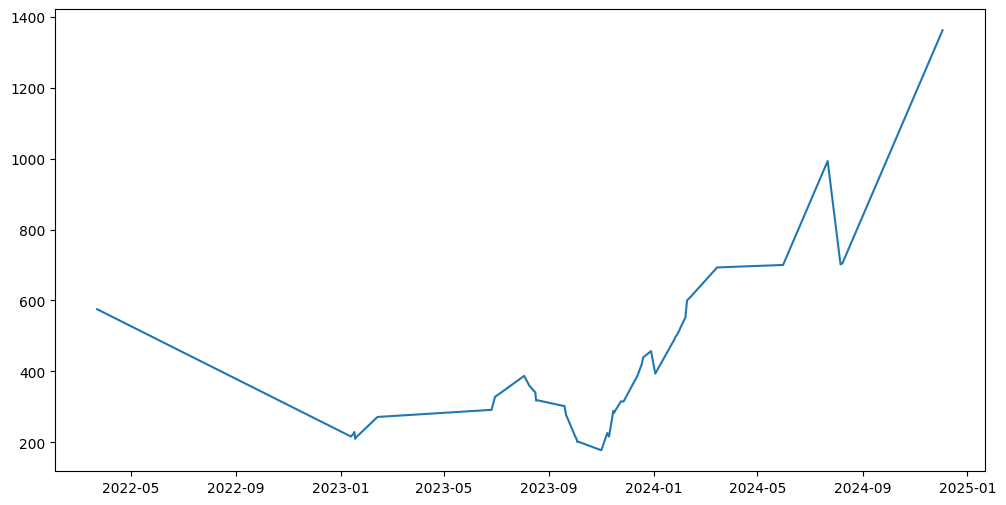

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(main_option_history['ts_event'], main_option_history['Value'], label='Option Value')